# Plotting Fractals

## Introduction

Fractals are beautiful, compelling mathematical forms that can be oftentimes created from a relatively simple set of instructions. In nature they can be found in various places, such as coastlines, seashells, and ferns, and even were used in creating certain types of antennas. The mathematical idea of fractals was known for quite some time, but they really began to be truly appreciated in the 1970's as advancements in computer graphics and some accidental discoveries lead researchers like Benoît Mandelbrot to stumble upon the truly mystifying visualizations that fractals possess.

This notebook will demonstrate how to plot these beautiful visualizations and will show a bit of basic exploration more familiarity of the mathematics behind fractals is gained and will use the ever powerful NumPy universal functions to perform the necessary calculations efficiently.

## Aims

* Write a function for plotting various `Julia sets`
* Create a visualization of the `Mandelbrot set`
* Write a function that computes `Newton fractals`
* Experiment with variations of general fractal types

## Objectives

* A better intuition for how fractals work mathematically
* A basic understanding about NumPy universal functions and Boolean Indexing
* The basics of working with complex numbers in NumPy
* How to create your own unique fractal visualizations

## Requirements

* NumPy
* Matplotlib
* `make_axis_locatable` function from mpl_toolkits API
* Some familiarity with Python, NumPy and matplotlib
* An idea of elementary mathematical functions, such as `exponents`, `sin`, `polynomials` etc
* A very basic understanding of `complex numbers` would be useful
* Knowledge of `derivatives` may be helpful

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Warmup

To gain some intuition for what fractals are, let's begin with an example. Consider the following equation:

$f(z) = z^2 -1$

where `z` is a complex number (i.e of the form $a + bi$).

For our convenience, we will write a Python function for it

In [2]:
def f(z):
    return np.square(z) - 1

To gain some intuition for the behaviour of the function, let's try plugging in some different values. For $z = 0$, the expected value is $-1$:

In [3]:
f(0)

-1

Since a universal function was used in the design, multiple inputs can be computed at the same time:

In [4]:
z = [4, 1 - 0.2j, 1.6]
f(z)

array([15.  +0.j , -0.04-0.4j,  1.56+0.j ])

Some values grow, some values shrink, some don’t experience much change. To see the behaviour of the function on a larger scale, apply the function to a subset of the complex plane and plot the result. To create the subset (or `mesh`), the `np.meshgrid` function can be used.

In [5]:
x, y = np.meshgrid(np.linspace(-10, 10, 20), np.linspace(-10, 10, 20))
mesh = x + (1j * y) # mesh of complex plane

Now apply the function to each value contained in the mesh. Since a universal function has been used in our design, this means that it is possible to pass in the entire mesh all at once. This is extremely convenient for two reasons: it reduces the amount of code needed to be written and greatly increases the efficiency (as universal functions make use of system level C programming in their computations).

Plot the absolute value (or modulus) of each element in the mesh after one "iteration" of the function using a `3D scatterplot`:

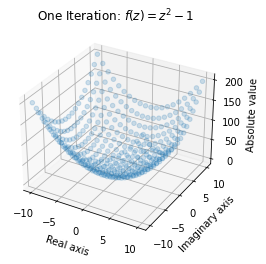

In [6]:
output = np.abs(f(mesh)) # take the absolute value of the output (for plotting)

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(x, y, output, alpha=0.2)
ax.set_xlabel("Real axis")
ax.set_ylabel("Imaginary axis")
ax.set_zlabel("Absolute value")
ax.set_title("One Iteration: $f(z) = z^2 - 1$")

plt.show()

This gives a rough idea of what one iteration of the function does. Certain areas (notably in the areas closest to $(0, 0i)$) remain rather small while other areas grow quite considerably. Note the lose of information about the output by taking the absolute value, but it is the only way to be able to make a plot.

Let’s see what happens when we apply 2 iterations to the mesh:

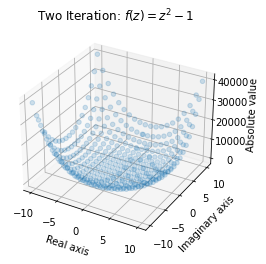

In [7]:
output = np.abs(f(f(mesh)))

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(x, y, output, alpha=0.2)
ax.set_xlabel("Real axis")
ax.set_ylabel("Imaginary axis")
ax.set_zlabel("Absolute value")
ax.set_title("Two Iteration: $f(z) = z^2 - 1$")

plt.show()

Once again, it can be seen that values around the origin remain small, and values with a larger absolute value (or modulus) "explode". From first impression, its behaviour appears to be normal, and may even seem mundane. Fractals tend to have more to them then what meets the eye; the exotic behavior shows itself when starting to apply more iterations.

Consider three complex numbers:

$z_1 = 0.4 + 0.4i$

$z_2 = z_1 + 0.1i$

$z_3 = z_1 + 0.1i$

Given the shape of our first two plots, it's expected that these values would remain near the origin as we apply iterations to them. Let's see what happens when applied 10 iterations to each value:

In [8]:
selected_values = np.array([0.4 + 0.4j, 0.41 + 0.4j, 0.4 + 0.41j])
num_iter = 9

outputs = np.zeros((num_iter+1, selected_values.shape[0]), dtype=complex)
outputs[0] = selected_values

for i in range(num_iter):
    outputs[i+1] = f(outputs[i]) # apply 10 iterations, save each output

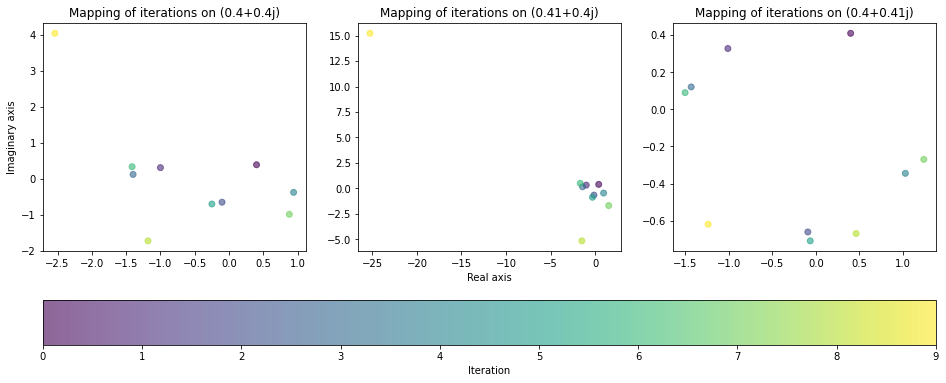

In [9]:
fig, axes = plt.subplots(1, selected_values.shape[0], figsize=(16, 6))

axes[1].set_xlabel("Real axis")
axes[0].set_ylabel("Imaginary axis")

for ax, data in zip(axes, outputs.T):
    cycle = ax.scatter(data.real, data.imag, c=range(data.shape[0]), alpha=0.6)
    ax.set_title(f"Mapping of iterations on {data[0]}")

fig.colorbar(cycle, ax=axes, location="bottom", label="Iteration")
plt.show()

As a surprise, the behaviour of the function did not come close to matching the previous hypothesis. This is a prime example of the chaotic behaviour fractals possess. In the first two plots, the value "exploded" on the last iteration, jumping way beyond the region that it was contained in previously. The third plot on the other hand remained bounded to a small region close to the origin, yielding completely different behaviour despite the tiny change in value.

This leads us to an extremely important question: __How many iterations can be applied to each value before they diverge ("explode")?__

As seen from the first two plots, the further the values were from the origin, the faster they generally exploded. Although the behaviour is uncertain for smaller values (like $z_1, z_2, z_3$), we can assume that if a value surpasses a certain distance from the origin (say 2) that it is doomed to diverge. This threshold is called the radius.

This enables to quantify the behaviour of the function for a particular value without having to perform as many computations. Once the radius is surpassed, it is allowed to stop iterating, which provides a way of answering the question posed just now. If someone tallies how many computations were applied before divergence, one can gain insight into the behaviour of the function that would be hard to keep track of otherwise.

Of course, it is also possible to do much better and design a function that performs the procedure on an entire mesh.

In [10]:
def divergence_rate(mesh, num_iter=10, radius=2):
    z = mesh.copy()
    diverge_len = np.zeros(mesh.shape) # keep tally of the number of iterations
    
    # iterate on element if and only if |element| < radius (Otherwise assume divergence)
    for i in range(num_iter):
        conv_mask = np.abs(z) < radius
        diverge_len[conv_mask] += 1
        z[conv_mask] = f(z[conv_mask])
    
    return diverge_len

The behaviour of this function may look confusing at first glance, so it will help to explain some of the notation.

The goal is to iterate over each value in the mesh and to tally the number of iterations before the value diverges. Since some values will diverge quicker than others, a procedure is needed that only iterates over values that have an absolute value that is sufficiently small enough. It may also be wished to stop tallying values once they surpass the radius. For this, `Boolean Indexing` can be used, a `NumPy` feature that when paired with universal functions is unbeatable. Boolean Indexing allows for operations to be performed conditionally on a NumPy array without having to resort to looping over and checking for each array value individually.

In our case, we use a loop to apply iterations to our function $f(z) = z^2 -1$ and keep tally. Using Boolean indexing, we only apply the iterations to values that have an absolute value less than 2.

With that out of the way, let's go about plotting the first fractal! The `imshow` function will be used to create a colour-coded visualization of the tallies.

In [11]:
x, y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
mesh = x + (1j * y)
output = divergence_rate(mesh)

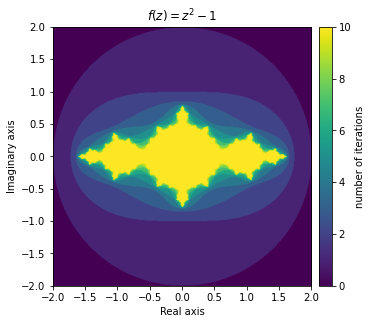

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()

ax.set_title("$f(z) = z^2 -1$")
ax.set_xlabel("Real axis")
ax.set_ylabel("Imaginary axis")

im = ax.imshow(output, extent=[-2, 2, -2, 2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label="number of iterations")

plt.show()

What this stunning visual conveys is the complexity of the function's behaviour. The yellow region represents values that remain small, while the purple region represents the divergent values. The beautiful pattern that arises on the border of the converging and diverging values is even more fascinating as it is created from such a simple function.

## Julia set

Consider the function $f(z) = z^2 + c$ where $c$ is a complex number. The __filled-in Julia set__ of $c$ is the set of all complex numbers `z` in which the function converges at $f(z)$. Likewise, the boundary of the filled-in Julia set is what is called the __Julia set__. In the above visualization, it can be seen that the yellow region represents an approximation of the filled-in Julia set for $c = -1$ and the greenish-yellow border would contain the Julia set.

To gain access to a wider range of "Julia fractals", let's write a function that allows for different values of $c$ to be passed in:

In [13]:
def julia(mesh, c=-1, num_iter=10, radius=2):
    z = mesh.copy()
    diverge_len = np.zeros(z.shape)
    
    for i in range(num_iter):
        conv_mask = np.abs(z) < radius
        z[conv_mask] = np.square(z[conv_mask]) + c
        diverge_len[conv_mask] += 1
    
    return diverge_len

To make things easier, let's create a couple meshes that will be reused throughout the rest of the notebook:

In [14]:
x, y = np.meshgrid(np.linspace(-1, 1, 400), np.linspace(-1, 1, 400))
small_mesh = x + (1j * y)

x, y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
mesh = x + (1j * y)

Let's also write a function that will be used to create fractal plots below:

In [15]:
def plot_fractal(fractal, title="Fractal", figsize=(6, 6), cmap="rainbow", extent=[-2, 2, -2, 2]):
    plt.figure(figsize=figsize)
    ax = plt.axes()
    
    ax.set_title(f"${title}$")
    ax.set_xlabel("real axis")
    ax.set_ylabel("imaginary axis")
    
    im = ax.imshow(fractal, extent=extent, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label="number of iterations")

Using the newly defined functions, it is possible make a quick plot of the first fractal again:

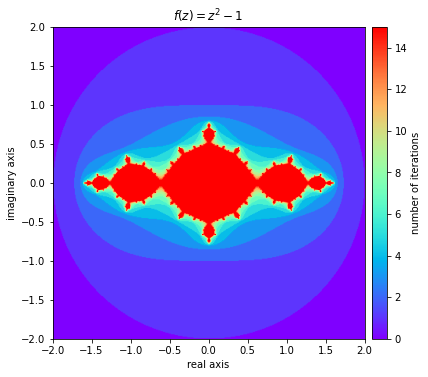

In [16]:
output = julia(mesh, num_iter=15)
kwargs = {"title": "f(z) = z^2 -1"}
plot_fractal(output, **kwargs)

It is also possible to explore some different Julia sets by experimenting with different values of $c$. It can be surprising how much influence it has on the shape of the fractal.

For example, setting $c = \frac{\pi}{10}$ gives us a very elegant cloud shape, while setting $c = -\frac{3}{4} + 0.4i$ yields a completely different pattern.

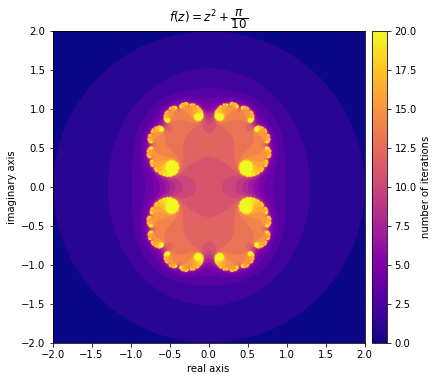

In [17]:
output = julia(mesh, c=np.pi/10, num_iter=20)
kwargs = {"title": "f(z) = z^2 + \dfrac{\pi}{10}", "cmap": "plasma"}
plot_fractal(output, **kwargs)

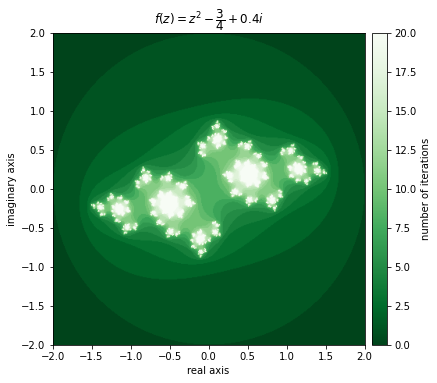

In [18]:
output = julia(mesh, c=-0.75 + 0.4j, num_iter=20)
kwargs = {"title": "f(z) = z^2 - \dfrac{3}{4} + 0.4i", "cmap": "Greens_r"}
plot_fractal(output, **kwargs)

## Mandelbrot set

Closely related to the Julia set is the famous `Mandelbrot set`, which has a slightly different definition. Once again, it is defined as $f(z) = z^2 + c$ where $c$ is a complex number, but this time the focus is on the choice of $c$. It is such that $c$ is an element of the Mandelbrot set if f converges at $z = 0$. An equivalent definition is to say that $c$ is an element of the Mandelbrot set if $f(c)$ can be iterated infinitely and not "explode". Let's tweak the Julia function slightly (and rename it appropriately) so a nice visualization can be plotted for the Mandelbrot set, which possesses an elegant fractal pattern.

In [19]:
def mandelbrot(mesh, num_iter=10, radius=2):
    c = mesh.copy()
    z = np.zeros(mesh.shape, dtype=np.complex128)
    diverge_len = np.zeros(z.shape)
    
    for i in range(num_iter):
        conv_mask = np.abs(z) < radius
        z[conv_mask] = np.square(z[conv_mask]) + c[conv_mask]
        diverge_len[conv_mask] += 1
    
    return diverge_len

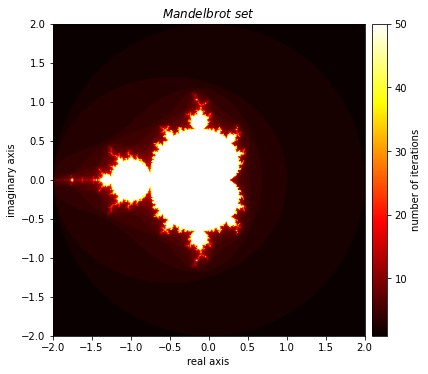

In [20]:
output = mandelbrot(mesh, num_iter=50)
kwargs = {"title": "Mandelbrot \ set", "cmap": "hot"}
plot_fractal(output, **kwargs)

## Generalizing the Julia set

The Julia function can be generalized even further by giving it a parameter for which universal function which is wished to be passed in. This would enable plotting fractals of the form $f(z) = g(z) + c$ where `g` is a universal function of preference.

In [21]:
def general_julia(mesh, c=-1, f=np.square, num_iter=100, radius=2):
    z = mesh.copy()
    diverge_len = np.zeros(z.shape)
    
    for i in range(num_iter):
        conv_mask = np.abs(z) < radius
        z[conv_mask] = f(z[conv_mask]) + c
        diverge_len[conv_mask] += 1
    
    return diverge_len

One cool set of fractals that can be plotted using our general Julia function are ones of the form $f(z) = z^n + c$ for some positive integer $n$. A very cool pattern which emerges is that the number of regions that "stick out" matches the degree in which we raise the function to while iterating over it.

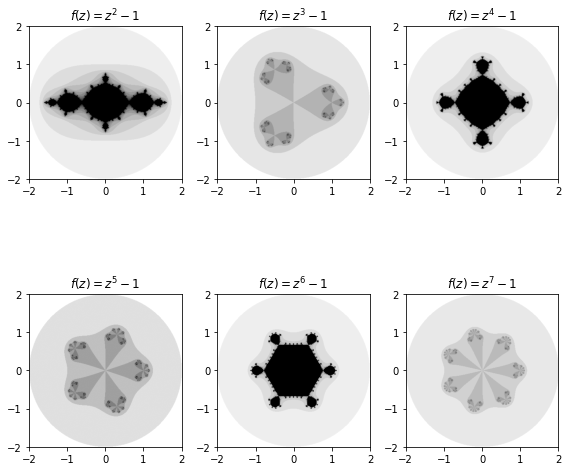

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8))
base_degree = 2

for deg, ax in enumerate(axes.ravel()):
    degree = base_degree + deg
    power = lambda z: np.power(z, degree) # create power function for current degree
    diverge_len = general_julia(mesh, f=power, num_iter=15)
    ax.imshow(diverge_len, extent=[-2, 2, -2, 2], cmap="binary")
    ax.set_title(f"$f(z) = z^{degree} - 1$")

fig.tight_layout()
plt.show()

Needless to say, there is a large amount of exploring that can be done by fiddling with the inputted function, value of $c$, number of iterations, radius and even the density of the mesh and choice of colours.

## Newton fractals

Newton fractals are a specific class of fractals, where iterations involve adding or subtracting the ratio of a function (often a polynomial) and its derivative to the input values. Mathematically, it can be expressed as:

$z := z - \frac{f(z)}{f'(z)}$

Let's define a general version of the fractal which will allow for different variations to be plotted by passing in functions of choice.

In [23]:
def newton_fractal(mesh, f, df, num_iter=10, r=2):
    z = mesh.copy()
    diverge_len = np.zeros(z.shape)
    
    for i in range(num_iter):
        conv_mask = np.abs(z) < r
        pz = f(z[conv_mask])
        dp = df(z[conv_mask])
        z[conv_mask] -= pz/dp
        diverge_len[conv_mask] += 1
    
    return diverge_len

Now this function can be experimented with some different functions. For polynomials, it is possible to create plots quite effortlessly using the `NumPy Polynomial class`, which has built in functionality for computing derivatives.

In [24]:
p = np.polynomial.Polynomial([-16, 0, 0, 0, 15, 0, 0, 0, 1])
print(f"{p=}")

p=Polynomial([-16.,   0.,   0.,   0.,  15.,   0.,   0.,   0.,   1.], domain=[-1,  1], window=[-1,  1])


$x \mapsto \text{-16.0}\color{LightGray}{ + \text{0.0}\,x}\color{LightGray}{ + \text{0.0}\,x^{2}}\color{LightGray}{ + \text{0.0}\,x^{3}} + \text{15.0}\,x^{4}\color{LightGray}{ + \text{0.0}\,x^{5}}\color{LightGray}{ + \text{0.0}\,x^{6}}\color{LightGray}{ + \text{0.0}\,x^{7}} + \text{1.0}\,x^{8}$

which has the derivative:

In [25]:
p.deriv()

Polynomial([ 0.,  0.,  0., 60.,  0.,  0.,  0.,  8.], domain=[-1.,  1.], window=[-1.,  1.])

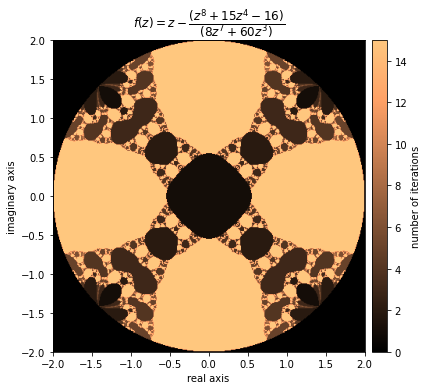

In [26]:
output = newton_fractal(mesh, p, p.deriv(), num_iter=15, r=2)
kwargs = {
    "title": "f(z) = z - \dfrac{(z^8 + 15z^4 - 16)}{(8z^7 + 60z^3)}",
    "cmap": "copper",
}

plot_fractal(output, **kwargs)

Beautiful! Let’s try another one:

$f(z) = tan^2(z)$

$\frac{df}{dz} = 2 \cdot tan(z) sec^2(z) =\frac{2 \cdot tan(z)}{cos^2(z)}$

This makes $\frac{f(z)}{f'(z)} =  tan^2(z) \cdot \frac{cos^2(z)}{2 \cdot tan(z)} = \frac{tan(z)\cdot cos^2(z)}{2} = \frac{sin(z)\cdot cos(z)}{2}$

In [27]:
def f_tan(z):
    return np.square(np.tan(z))

In [28]:
def d_tan(z):
    return 2 * np.tan(z) / np.square(np.cos(z))

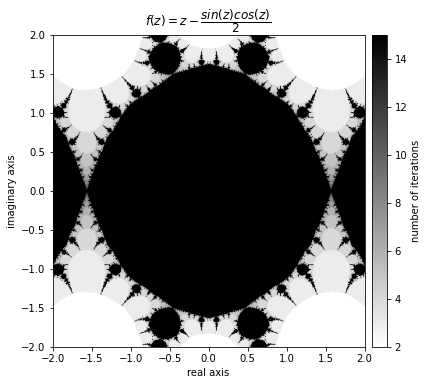

In [29]:
output = newton_fractal(mesh, f_tan, d_tan, num_iter=15, r=50)
kwargs = {
    "title": "f(z) = z - \dfrac{sin(z)cos(z)}{2}",
    "cmap": "binary",
}

plot_fractal(output, **kwargs)

Note that it is exciting to sometimes to play with the radius in order to get a neat looking fractal.

Finally, it is possible go a little bit wild with the function selection

$f(z) = \sum_{i=1}^{10} sin^i(z)$

$\frac{df}{dz} = \sum_{i=1}^{10} i \cdot sin^{i-1}(z) \cdot cos(z)$

In [30]:
def sin_sum(z, n=10):
    total = np.zeros(z.size, dtype=z.dtype)
    
    for i in range(1, n+1):
        total += np.power(np.sin(z), i)
    
    return total

In [31]:
def d_sin_sum(z, n=10):
    total = np.zeros(z.size, dtype=z.dtype)
    
    for i in range(1, n+1):
        total += i * np.power(np.sin(z), i-1) * np.cos(z)
    
    return total

Let's denote this one "Wacky fractal", as its equation would not be fun to try and put in the title.

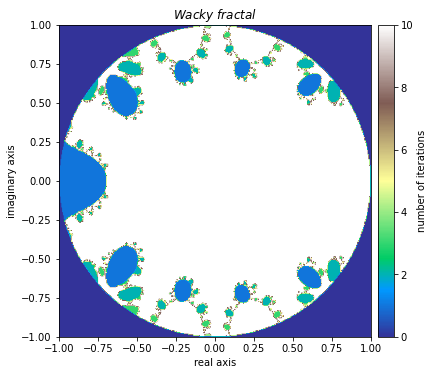

In [32]:
output = newton_fractal(small_mesh, sin_sum, d_sin_sum, num_iter=10, r=1)
kwargs = {
    "title": "Wacky \ fractal",
    "figsize": (6, 6),
    "extent": [-1, 1, -1, 1],
    "cmap": "terrain",
}

plot_fractal(output, **kwargs)